# Mount Data from Google Drive

In [0]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading Kaggle All News dataset 



## Libraries

In [45]:
import pandas as pd
import numpy as np
import csv
import os
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk

from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
stemmer=PorterStemmer()


import matplotlib.pyplot as mp
%matplotlib inline
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from kaggle. (https://www.kaggle.com/snapcrack/all-the-news/home#articles3.csv)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Parameter

In [0]:
runParams={'sentiment_library':   ['vader'],
           'input_file':          ['/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/all-news-kaggle/articles1.csv'],
           'output_file':         ['/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/all-news-kaggle/fakenews_by_news-coverage.csv'],
           'article_id_list':     [[120639,80103,25225,21502,57362,120636]],
           'sentiment_sentences': [5],
           'article_stats':       [False]}

# Use parameter grid even if there is only set of parameters
parameterGrid=ParameterGrid(runParams)

# Preprocessing

### Cleaning Data

In [0]:
def getInputDataAndDisplayStats(filename,processDate,printSummary=False):

	df=pd.read_csv(filename)

	df=df.drop_duplicates('content')
	df=df[~df['content'].isnull()]

	
	df=df[df['content'].str.len()>=200]

	# Find and remove summary NYT "briefing" articles to avoid confusing the clustering
	targetString="(Want to get this briefing by email?"
	df['NYT summary']=df['content'].map(lambda d: d[:len(targetString)]==targetString)
	df=df[df['NYT summary']==False]

	
	# And subsequently to the assessment of sentiment
	targetString="For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below"
	df['content']=df['content'].str.replace(targetString,'')

	# This is also for some Atlantic articles for the same reasons as above
	targetString="This article is part of a feature we also send out via email as The Atlantic Daily, a newsletter with stories, ideas, and images from The Atlantic, written specially for subscribers. To sign up, please enter your email address in the field provided here."
	df=df[df['content'].str.contains(targetString)==False]

	# This is also for some Atlantic articles for the same reasons as above
	targetString="This article is part of a feature we also send out via email as Politics  Policy Daily, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here."
	df=df[df['content'].str.contains(targetString)==False]

	# More Atlantic-specific removals (for daily summaries with multiple stories contained)
	df=df[df['content'].str.contains("To sign up, please enter your email address in the field")==False]

	# Remove daily CNN summary
	targetString="CNN Student News"
	df=df[df['content'].str.contains(targetString)==False]

	if printSummary:
		print("\nArticle counts by publisher:")
		print(df['publication'].value_counts())

		print("\nArticle counts by date:")
		print(df['date'].value_counts())
		

	if processDate!=None:
		df=df[df['date']==processDate]
	df.reset_index(inplace=True, drop=True)

	# Remove non-ASCII characters
	df['processed_content']=df['content'].map(lambda x: removeNonASCIICharacters(x))
	df['score'] = 0.0

	print("\nFinal dataset:\n\nDate:",processDate,"\n")
	print(df['publication'].value_counts())

	return df

##########################################################################################

def removeNonASCIICharacters(textString): 
    return "".join(i for i in textString if ord(i)<128)

In [18]:
all_news=getInputDataAndDisplayStats(runParams['input_file'][0],None,False)


Final dataset:

Date: None 

Breitbart           23585
CNN                 11249
New York Times       7620
Business Insider     6504
Atlantic              157
Name: publication, dtype: int64


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

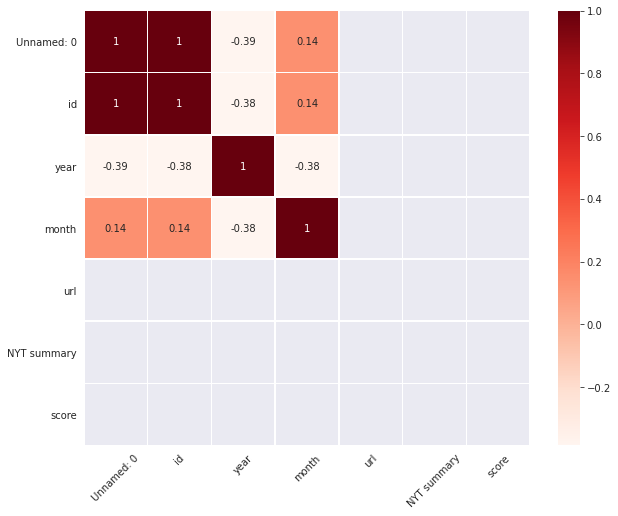

In [42]:
figure, axes = mp.subplots(figsize=(10,8))
sns.heatmap(all_news.corr(), annot=True, vmax=1, linewidths=.5, cmap='Reds')
mp.xticks(rotation=45)

### Data

In [0]:
data_text = all_news[['processed_content']]
data_text['index'] = data_text.index
documents = data_text



In [20]:
print(len(documents))
print(documents[:5])

49115
                                   processed_content  index
0  WASHINGTON     Congressional Republicans have ...      0
1  After the bullet shells get counted, the blood...      1
2  When Walt Disneys Bambi opened in 1942, critic...      2
3  Death may be the great equalizer, but it isnt ...      3
4  SEOUL, South Korea     North Koreas leader, Ki...      4


### Libraries

In [0]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

### After Preprocessing

In [23]:
doc_sample = documents[documents['index'] == 4310].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Its', 'hard', 'to', 'remember', 'a', 'time', 'when', 'the', 'tense', '2016', 'presidential', 'campaign', 'didnt', 'hog', 'the', 'airwaves', 'and', 'social', 'media', 'feeds.', 'It', 'has', 'also', 'sucked', 'the', 'oxygen', 'at', 'social', 'gatherings,', 'according', 'to', 'a', 'number', 'of', 'New', 'Yorkers', 'who', 'are', 'regulars', 'on', 'the', 'party', 'circuit.', 'At', 'any', 'recent', 'outing,', 'the', 'acrimonious', 'contest', 'between', 'Hillary', 'Clinton', 'and', 'Donald', 'J.', 'Trump', 'is', 'the', 'elephant', 'in', 'the', 'room,', 'the', 'uninvited', 'guest.', 'The', 'subject', 'can', 'derail', 'restaurant', 'conversation,', 'make', 'hostages', 'of', '', '', 'guests', 'and', 'drive', 'a', 'wedge', 'between', 'host', 'and', 'guest.', 'At', 'a', 'dinner', 'with', 'friends', 'Saturday,', 'the', 'literary', 'agent', 'Chris', 'Calhoun,', 'thinking', 'the', 'conversation', 'would', 'be', 'about', 'a', 'play', 'they', 'were', 'about', 'to', 'see,', 'found'

Preprocess the 'content' text, saving the results as ‘processed_docs’

In [24]:
processed_docs = documents['processed_content'].map(preprocess)
processed_docs[:10]

0    [washington, congression, republican, fear, co...
1    [bullet, shell, count, blood, dri, votiv, cand...
2    [walt, disney, bambi, open, critic, prais, spa...
3    [death, great, equal, isnt, necessarili, evenh...
4    [seoul, south, korea, north, korea, leader, sa...
5    [london, queen, elizabeth, battl, cold, week, ...
6    [beij, presid, tsai, taiwan, sharpli, critic, ...
7    [danni, cahil, stand, slightli, daze, blizzard...
8    [hillari, kerr, founder, digit, media, compani...
9    [angel, muiz, famili, apart, bronx, paint, ang...
Name: processed_content, dtype: object

## Bag of Words on the Data set

creating dictionary from ‘processed_docs’ containing the number of times a word appears in the training set

In [25]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 access
1 acknowledg
2 administr
3 advoc
4 afford
5 alli
6 american
7 anger
8 annual
9 anticip
10 appeal


## Filter out tokens

* less than 15 documents (absolute number) or
* more than 0.5 documents (fraction of total corpus size, not absolute number).
* after the above two steps, keep only the first 100000 most frequent tokens.

In [0]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

## Gensim doc2bow

In [27]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(6, 2),
 (16, 1),
 (17, 2),
 (19, 1),
 (27, 2),
 (34, 1),
 (36, 2),
 (60, 1),
 (67, 3),
 (74, 1),
 (78, 3),
 (80, 4),
 (82, 1),
 (86, 1),
 (98, 3),
 (99, 2),
 (103, 5),
 (106, 1),
 (120, 1),
 (122, 2),
 (130, 1),
 (137, 1),
 (138, 1),
 (143, 1),
 (147, 1),
 (162, 7),
 (172, 2),
 (185, 1),
 (186, 2),
 (195, 1),
 (196, 1),
 (205, 1),
 (207, 4),
 (210, 1),
 (215, 2),
 (227, 2),
 (233, 9),
 (238, 3),
 (242, 5),
 (244, 1),
 (248, 1),
 (251, 1),
 (260, 4),
 (278, 3),
 (296, 1),
 (297, 1),
 (310, 1),
 (319, 1),
 (328, 1),
 (334, 2),
 (336, 1),
 (338, 10),
 (344, 1),
 (345, 1),
 (353, 1),
 (362, 1),
 (366, 1),
 (389, 10),
 (399, 1),
 (400, 1),
 (401, 1),
 (405, 1),
 (409, 1),
 (419, 2),
 (431, 1),
 (436, 1),
 (437, 3),
 (438, 1),
 (449, 8),
 (457, 1),
 (471, 1),
 (486, 1),
 (489, 3),
 (491, 1),
 (508, 1),
 (513, 4),
 (520, 7),
 (530, 1),
 (548, 1),
 (551, 1),
 (556, 2),
 (558, 1),
 (568, 1),
 (574, 1),
 (584, 2),
 (596, 1),
 (604, 1),
 (612, 1),
 (613, 4),
 (614, 4),
 (623, 1),
 (627, 1),
 (6

In [28]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 6 ("american") appears 2 time.
Word 16 ("avoid") appears 1 time.
Word 17 ("awkward") appears 2 time.
Word 19 ("behalf") appears 1 time.
Word 27 ("case") appears 2 time.
Word 34 ("circuit") appears 1 time.
Word 36 ("come") appears 2 time.
Word 60 ("defend") appears 1 time.
Word 67 ("discuss") appears 3 time.
Word 74 ("donald") appears 1 time.
Word 78 ("effect") appears 3 time.
Word 80 ("elect") appears 4 time.
Word 82 ("entir") appears 1 time.
Word 86 ("execut") appears 1 time.
Word 98 ("give") appears 3 time.
Word 99 ("govern") appears 2 time.
Word 103 ("happen") appears 5 time.
Word 106 ("hous") appears 1 time.
Word 120 ("involv") appears 1 time.
Word 122 ("john") appears 2 time.
Word 130 ("lead") appears 1 time.
Word 137 ("longer") appears 1 time.
Word 138 ("lose") appears 1 time.
Word 143 ("money") appears 1 time.
Word 147 ("obama") appears 1 time.
Word 162 ("polit") appears 7 time.
Word 172 ("presidenti") appears 2 time.
Word 185 ("quickli") appears 1 time.
Word 186 ("race") a

## TF-IDF

In [29]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.026850989614062636),
 (1, 0.029044032540929802),
 (2, 0.232311312242301),
 (3, 0.031797689999003696),
 (4, 0.03329228524952793),
 (5, 0.02833702612395988),
 (6, 0.011766822230301434),
 (7, 0.03653462102601982),
 (8, 0.03140703989982658),
 (9, 0.08219960613745092),
 (10, 0.11846915131609712),
 (11, 0.1068141918053446),
 (12, 0.029513613549770498),
 (13, 0.03979009708681564),
 (14, 0.03428077277988951),
 (15, 0.03479978142159557),
 (16, 0.028503706847844302),
 (17, 0.0495297404907489),
 (18, 0.043142692169754575),
 (19, 0.037134864501421457),
 (20, 0.0527363861101117),
 (21, 0.05903826075824045),
 (22, 0.19672522175807255),
 (23, 0.038831298952129334),
 (24, 0.038524626844953974),
 (25, 0.16426232704083849),
 (26, 0.06347270799769901),
 (27, 0.06744844218597165),
 (28, 0.04155808411410557),
 (29, 0.027992921388341353),
 (30, 0.02315719889641414),
 (31, 0.036105946833063944),
 (32, 0.04028460608862562),
 (33, 0.05151271233063667),
 (34, 0.04463941601828153),
 (35, 0.043300305958874

# LDA using TF-IDF

In [30]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.007*"polic" + 0.004*"shoot" + 0.004*"attack" + 0.003*"offic" + 0.003*"kill" + 0.002*"suspect" + 0.002*"citi" + 0.002*"israel" + 0.002*"arrest" + 0.002*"investig"
Topic: 1 Word: 0.002*"film" + 0.002*"star" + 0.002*"game" + 0.002*"trump" + 0.001*"women" + 0.001*"play" + 0.001*"movi" + 0.001*"black" + 0.001*"love" + 0.001*"season"
Topic: 2 Word: 0.010*"trump" + 0.006*"clinton" + 0.004*"republican" + 0.003*"campaign" + 0.003*"democrat" + 0.003*"vote" + 0.003*"hillari" + 0.003*"presid" + 0.003*"obama" + 0.003*"elect"
Topic: 3 Word: 0.004*"clinton" + 0.004*"court" + 0.003*"trump" + 0.002*"justic" + 0.002*"comey" + 0.002*"investig" + 0.002*"depart" + 0.002*"email" + 0.002*"feder" + 0.002*"attorney"
Topic: 4 Word: 0.005*"tesla" + 0.003*"market" + 0.003*"compani" + 0.002*"climat" + 0.002*"price" + 0.002*"musk" + 0.002*"bank" + 0.002*"stock" + 0.002*"growth" + 0.002*"investor"
Topic: 5 Word: 0.008*"cartel" + 0.006*"uber" + 0.004*"mexican" + 0.004*"cosbi" + 0.004*"texa" + 0.003*"

## Reference

1. https://www.nltk.org/book/ch05.html
2.  https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
3. https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24